In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [63]:
df1=pd.read_csv('joined_20190911192433.csv', index_col=0, parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,19,20,21,27,29,34,37,38,40,41,46,47,48,49,50,53,54,55,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
df1.head(20)

,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,Building Grade2,...,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Building Type Custom,Land Area Acres,Sales Count
0,$0,"$2,655","$2,655",2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7500.0,0.0,2655.0,10621.0,2655.0,10621.0,0.0,NaN,7.60,0
1,$0,"$4,081","$4,081",2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,12500.0,0.0,4081.0,16323.0,4081.0,16323.0,0.0,NaN,8.90,0
2,$0,$0,$0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,67000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.90,0
3,$0,$0,$0,2019.0,2.0,NaN,Poor,NaN,E,NaN,...,67000.0,34800.0,0.0,12300.0,0.0,47100.0,1224.0,SINGLE FAM,0.79,0
4,$0,$0,$0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,67000.0,0.0,0.0,27400.0,0.0,27400.0,0.0,NaN,2.11,0
5,"$6,950","$6,250","$13,200",2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,50000.0,27800.0,13200.0,25000.0,6250.0,52800.0,0.0,NaN,0.73,1
6,"$22,175","$11,675","$33,850",2019.0,1.0,NaN,Fair,NaN,D,NaN,...,95000.0,88700.0,33850.0,46700.0,11675.0,135400.0,1920.0,SINGLE FAM,3.11,1
7,"$27,425","$10,025","$37,450",2019.0,2.0,NaN,Average,NaN,C,NaN,...,115000.0,109700.0,37450.0,40100.0,10025.0,149800.0,1464.0,SINGLE FAM,2.57,0
8,$0,"$4,950","$4,950",2019.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,4950.0,19800.0,4950.0,19800.0,0.0,NaN,1.17,1
9,$0,$0,$0,2019.0,2.0,NaN,Average,NaN,C,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1787.0,SINGLE FAM,0.45,1


In [64]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [65]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()

In [66]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']=df['Log NbhdPPS'].replace(np.inf, np.nan)
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdRatio']=df['Log NbhdRatio'].replace(np.inf, np.nan)
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

In [67]:
nbhdsales=df.groupby('Neighborhood')['Sales Count'].median().to_frame().rename(columns={'Sales Count':'Nbhd Sales'})
df=df.merge(nbhdsales, how='left', left_on = 'Neighborhood',right_index=True)

In [68]:
df['Log NbhdSales']= df['Nbhd Sales'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None).replace(np.inf, np.nan)


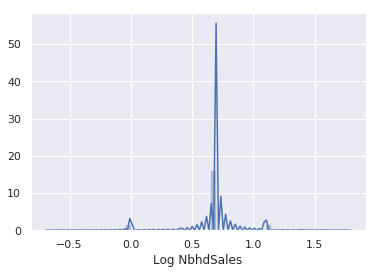

In [69]:
sns.distplot(df['Log NbhdSales'])

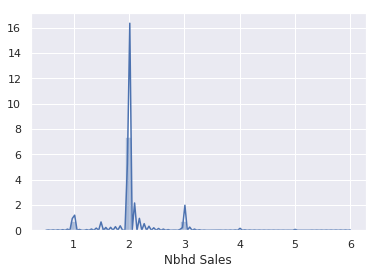

In [70]:
sns.distplot(df['Nbhd Sales'])

In [71]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error as MSLE

In [72]:
df2 = df[['Nbhd Sales','Log NbhdRatio','Building Condition','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built', 'Zone']]
df2=df2.dropna()

In [73]:
df2.columns = ['Nbhd-Sales','Log-NbhdRatio','Building-Condition', 'Log-SqFt', 'Log-Fixtures',
       'Building-Type-Custom', 'Building-Grade', 'Exterior-Wall', 'Year',
       'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 'Year-Built', 'Zone']

In [92]:
from sklearn.model_selection import train_test_split
X= pd.get_dummies(df2[['Nbhd-Sales','Zone','Log-NbhdPPS','Building-Grade','Year', 'Log-Assessment','Log-Fixtures','Exterior-Wall','Year-Built']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [93]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_yyytest))**0.5)
print(MSE(y_pred, y_test)**0.5)

87.2535827929958


In [94]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(y_pred, y_test)**0.5)
#Out of the box, this is a decent score. 

50.64722918034702


In [95]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


42.3231755872563


In [99]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test,y_test)
evals_result={}
params = {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 600, 'num_leaves': 350}
gbm = lgb.train(params=params,
                train_set= dtrain,
                valid_sets=[dtrain, dvalid],
                num_boost_round=400,
                evals_result=evals_result,
                verbose_eval=10)
y_predgbm=gbm.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predgbm)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predgbm)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predgbm)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predgbm)))
print('Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predgbm),np.abs(y_test))))

/home/drew/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE: 40.005470839208655
Median Absolute Error: 14.428916627342112
Mean Absolute Error: 22.850758550462
Coefficient of Determination: 0.779587994668044
Mean Squared Logarithmic Error: 0.05086193387724552
